# Hunting for Polysemantic Neurons

# Introduction & loading content

 This notebook is a exploration of the 

In [3]:
#This notebook is the expoloration for neurons that encode for multiple features. Based on work done by Neel Nanda, & Anthropic

#Code in this notebook was authored by Neel Nanda, and edited for my own puposes.
#Source:

#General
#My goal is to find polysemantic neurons, from the GPT2 smol model.
#In general, I want to  figure out what is the search space of my problem
# How can I measure whether 2 neurons are polysemantic?
# Are there different ways to performs this measurement?

#Ok so the thoery could be to pass multiple texts through the netwrok to see what gets activated.
# Do certain neurons fire together when specific ideas/topics/words who up under different circumstances?

#that neurons are "polysemantic", responding to several unrelated features.
#Instead it's this, its the idea that a single neuron accounts of differenet unrelated pieces of information.
# I mean this is extremely similar to how the brain works. Memories are not all kept in the same place.
#Thinking on this further, Ai researchers are truly on the path to create immortal entities that are able to shift to a new 
# computational piece of silicone once they notice a certain level of degradation.


 "With Artifical
 
 This is a colab notebook dedicated to expoloring either intersting neurons, and attempting to find polysemantic neurons.

Imports & setup

In [4]:
#mounting my local drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Checking for Google Colab
#Neel Nanda code

import os
import numpy as np
from IPython.core.display import HTML
from IPython.display import HTML

try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook


In [6]:
#Neel Nanda code
#Sets up transformers github file
if IN_COLAB:
    os.system("pip install git+https://github.com/neelnanda-io/TransformerLens.git")
    os.system("pip install gradio")

import gradio as gr
from transformer_lens import HookedTransformer
from transformer_lens.utils import to_numpy

#checking on directory
%cd drive/MyDrive/Colab Notebooks/Mechanistic Interpretability/Polysemantic-Neurons
!ls

/content/drive/MyDrive/Colab Notebooks/Mechanistic Interpretability/Polysemantic-Neurons
all_50_neurons_math.csv        top_500_neurons_math.csv
Polysemantic_neurons.ipynb     top_500_neurons_nba.csv
README.md		       top_500_neurons_nintendo.csv
top_100_neurons_fortran.csv    top_500_neurons_python_an.csv
top_100_neurons_gibberish.csv  top_500_neurons_python_pr.csv
top_100_neurons_medical.csv    top_500_neurons_sail.csv
top_100_neurons_spanish.csv    top_500_neurons_tech.csv
top_500_neurons_cook.csv       top_500_neurons_travel.csv


Setting up Solu4l

In [7]:
#Bringing in GPT2 smol version, and setting up the custom hooks
model_name = "solu-4l"
model = HookedTransformer.from_pretrained(model_name)

Loaded pretrained model solu-4l into HookedTransformer


Neuron activation function definition

In [8]:
#Neel Nanda
#Function definition to extract neuron activations
def get_neuron_acts(text, layer, neuron_index):
    # Hacky way to get out state from a single hook - we have a single element list and edit that list within the hook.
    cache = {}

    def caching_hook(act, hook):
        cache["activation"] = act[0, :, neuron_index]

    model.run_with_hooks(
        text, fwd_hooks=[(f"blocks.{layer}.mlp.hook_post", caching_hook)]
    )
    return to_numpy(cache["activation"])

## Visualization Definition

This section just defines the functions need to visualize the activations of a specific neuron on input text. Written by Neel Nanda

In [71]:
#Neel Nanda's code

# This is some CSS (tells us what style )to give each token a thin gray border, to make it easy to see token separation
style_string = """<style> 
    span.token {
        border: 1px solid rgb(123, 123, 123)
        } 
    </style>"""


def calculate_color(val, max_val, min_val):
    # Hacky code that takes in a value val in range [min_val, max_val], normalizes it to [0, 1] and returns a color which interpolates between slightly off-white and red (0 = white, 1 = red)
    # We return a string of the form "rgb(240, 240, 240)" which is a color CSS knows
    normalized_val = (val - min_val) / max_val
    return f"rgb(240, {240*(1-normalized_val)}, {240*(1-normalized_val)})"

import numpy as np

def basic_neuron_vis(text, layer, neuron_index, max_val=None, min_val=None):
    """
    text: The text to visualize
    layer: The layer index
    neuron_index: The neuron index
    max_val: The top end of our activation range, defaults to the maximum activation
    min_val: The top end of our activation range, defaults to the minimum activation

    Returns a string of HTML that displays the text with each token colored according to its activation

    Note: It's useful to be able to input a fixed max_val and min_val, because otherwise the colors will change as you edit the text, which is annoying.
    """
    if layer is None:
        return "Please select a Layer"
    if neuron_index is None:
        return "Please select a Neuron"
    acts = get_neuron_acts(text, layer, neuron_index)
    act_max = acts.max()
    act_min = acts.min()
    # Defaults to the max and min of the activations
    if max_val is None:
        max_val = act_max
    if min_val is None:
        min_val = act_min
    # We want to make a list of HTML strings to concatenate into our final HTML string
    # We first add the style to make each token element have a nice border
    htmls = [style_string]
    # We then add some text to tell us what layer and neuron we're looking at - we're just dealing with strings and can use f-strings as normal
    # h4 means "small heading"
    htmls.append(f"<h4>Layer: <b>{layer}</b>. Neuron Index: <b>{neuron_index}</b></h4>")
    # We then add a line telling us the limits of our range
    htmls.append(
        f"<h4>Max Range: <b>{max_val:.4f}</b>. Min Range: <b>{min_val:.4f}</b></h4>"
    )
    # If we added a custom range, print a line telling us the range of our activations too.
    if act_max != max_val or act_min != min_val:
        htmls.append(
            f"<h4>Custom Range Set. Max Act: <b>{act_max:.4f}</b>. Min Act: <b>{act_min:.4f}</b></h4>"
        )
    # Convert the text to a list of tokens
    str_tokens = model.to_str_tokens(text)
    for tok, act in zip(str_tokens, acts):
        # A span is an HTML element that lets us style a part of a string (and remains on the same line by default)
        # We set the background color of the span to be the color we calculated from the activation
        # We set the contents of the span to be the token
        htmls.append(
            f"<span class='token' style='background-color:{calculate_color(act, max_val, min_val)}' >{tok}</span>"
        )

    return "".join(htmls), acts



# Initialize input text

These are 9 examples that are meant to be quite different  in subject matter to be interpreted as different text by the neural network. 
The 9 features are set up in such a way to generate multiple examples, in an attempt to truly measure if the SoLU netis activating on multiiple examples of the same subject.
These texts below were generated with May 6th version of GPT4. I initially elected to only use GPT3.5, however the sentences didn't have as much complexity in each example.

In [10]:
#Defining my input word features



cooking_examples = [
    "Cooking is a creative process that involves preparing food by combining, mixing, and heating ingredients to create delicious and nutritious meals.",
    "Baking is a popular method of cooking that uses dry heat in an oven to prepare cakes, bread, pastries, and other desserts.",
    "Sous vide is a cooking technique where vacuum-sealed food is submerged in a temperature-controlled water bath, resulting in even and precise cooking.",
    "Grilling is a high-heat method of cooking where food is cooked over an open flame, giving it a delicious smoky flavor and caramelized crust.",
    "Sauteing is a quick cooking method where food is cooked in a small amount of fat over high heat, allowing for browning and developing flavors."
]

nba_examples = [
    "The NBA is a professional basketball league in the United States, consisting of 30 teams and widely considered the premier men's basketball league globally.",
    "LeBron James is an NBA superstar who has played for the Cleveland Cavaliers, Miami Heat, and Los Angeles Lakers, winning multiple championships.",
    "The NBA All-Star Game is an annual exhibition match where fans vote for their favorite players to compete in a friendly game showcasing their skills.",
    "The NBA Draft is an annual event where teams select eligible players to join their rosters, often selecting young talent from college basketball programs.",
    "The NBA playoffs are a series of elimination rounds that determine the champion of the league, culminating in the NBA Finals between the conference winners."
]

sailing_examples = [
    "Sailing is a recreational and competitive sport that involves navigating a boat using the wind to propel it across the water.",
    "Regattas are organized sailing events that consist of multiple races, often featuring various boat classes and attracting sailors of different skill levels.",
    "Yachting is a form of sailing that involves recreational cruising or racing on larger, more luxurious boats, often in prestigious events.",
    "The America's Cup is the oldest international sailing competition, featuring high-tech, cutting-edge boats competing in a series of races for the coveted trophy.",
    "Sailboats come in various sizes and designs, from small dinghies to large, multi-hulled catamarans, each suited to specific sailing conditions and purposes."
]

travel_examples = [
    "Travel allows people to experience new cultures, meet new people, and gain a broader perspective on the world by exploring different destinations.",
    "Eco-tourism focuses on responsible travel to natural areas, aiming to conserve the environment, promote sustainable practices, and support local communities.",
    "Adventure travel is a type of tourism that involves exploration and physical challenges, such as hiking, mountain climbing, or whitewater rafting.",
    "Cultural travel is the exploration of a destination's history, art, architecture, and traditions, immersing oneself in the local customs and heritage.",
    "Culinary travel is a popular trend where travelers seek out unique food experiences, exploring local cuisine and learning about regional culinary traditions."
]

technology_examples = [
    "Technology has revolutionized our daily lives, enabling instant communication, access to information, and increased productivity through various digital tools.",
    "Artificial intelligence is a branch of computer science that seeks to create machines capable of learning, reasoning, and problem-solving like humans.",
    "Virtual reality is an immersive technology that allows users to experience computer-generated environments and interact with digital objects in 3D space.",
    "The Internet of Things (IoT) refers to the network of interconnected devices that communicate and exchange data, enabling smarter, more efficient systems.",
    "Blockchain technology is a decentralized, digital ledger that records transactions across multiple computers, providing increased"]

mobile_nintendo_games_examples = [
    "Nintendo has expanded its presence in the mobile gaming market with popular titles such as Mario Kart Tour, Pokémon GO, and Animal Crossing: Pocket Camp.",
    "Super Mario Run is a side-scrolling, auto-runner mobile game developed by Nintendo, bringing the iconic Mario gameplay to smartphones.",
    "Fire Emblem Heroes is a mobile strategy RPG game by Nintendo, featuring characters from the Fire Emblem series in a free-to-play format.",
    "Dragalia Lost is an action RPG mobile game by Nintendo and Cygames, with players controlling a variety of characters as they explore a fantasy world.",
    "Pokémon Masters EX is a mobile game by Nintendo and DeNA, featuring team battles with famous trainers from the Pokémon series in a real-time strategy format."
]

python_programming_examples = [
    "Python is a high-level, interpreted programming language known for its simplicity, readability, and versatility in various application domains.",
    "The Python Package Index (PyPI) is a repository of software packages for Python, allowing users to install and manage libraries for their projects.",
    "Python's extensive ecosystem of libraries, such as NumPy for numerical computing or TensorFlow for machine learning, makes it a popular choice among developers.",
    "Django and Flask are two popular web frameworks for building web applications using Python, each offering a different approach to web development.",
    "Jupyter Notebook is an interactive computing environment that allows users to create and share live code, equations, visualizations, and narrative text using Python and other languages."
]

python_animal_examples = [
    "The python is a family of nonvenomous snakes found in Africa, Asia, and Australia, characterized by their large size and constricting behavior.",
    "Ball pythons are a popular species of python in the pet trade, known for their docile nature, manageable size, and variety of color morphs.",
    "Python's unique method of hunting involves wrapping around its prey, constricting it until it suffocates, and then swallowing it whole.",
    "Green tree pythons are known for their striking appearance, with bright green scales and a prehensile tail that helps them navigate their arboreal habitat.",
    "Reticulated pythons are among the longest snake species in the world, with some individuals reaching lengths of over 20 feet."
]


math_examples = [
    "The square of a number x can be represented as x^2, which is the result of multiplying the number by itself. For example, the square of 3 is 3^2 = 3*3 = 9.",
    "To find the difference between two numbers, you can subtract the smaller number from the larger one. For instance, the difference between 7 and 4 is 7 - 4 = 3.",
    "The sum of two numbers can be found by adding them together. For example, the sum of 5 and 2 is 5 + 2 = 7.",
    "Dividing a number by another gives the quotient. For example, dividing 15 by 3 results in a quotient of 5, represented as 15 / 3 = 5.",
    "To calculate the cube of a number x, you can multiply the number by itself twice, represented as x^3. For instance, the cube of 2 is 2^3 = 2*2*2 = 8."
]




# Solu4: 1st run

The function below is a systematic approach to finding all of the neuron activations for a list of different text items. Input parameters 

In [64]:

def find_top_neurons(text_list, top_n=100):
    #changing this to be a minimum val
    layer = [0, 1,2,3]
    neuron_indices = range(2048)

    # Store activations and neuron indices as tuples
    neuron_activations = {layer_num: {neuron_index: [] for neuron_index in neuron_indices} for layer_num in layer}

    for text in text_list:
        print(" On text ",text)
        for layer_num in layer:
            #print("On layer",layer_num)
            for neuron_index in neuron_indices:
                acts = get_neuron_acts(text, layer_num, neuron_index)
                activation_value = acts.mean()
                neuron_activations[layer_num][neuron_index].append(activation_value)

    # Calculate the mean activations for each neuron across all texts
    mean_activations = []
    for layer_num in layer:
        for neuron_index in neuron_indices:
            mean_activation = sum(neuron_activations[layer_num][neuron_index]) / len(text_list)
            mean_activations.append((layer_num, neuron_index, mean_activation))

    # Sort neurons based on mean activations
    sorted_neurons = sorted(mean_activations, key=lambda x: x[2], reverse=True)

    # Return Top N neurons
    return sorted_neurons[:top_n], acts



The hypothesis is that if I can run multiple texts with different levels of information(features), are there specific neurons that only light up for only 2 features? It could be that the neurons found indeed only encode for those two feautres such as knowledge on cooking and programming in Python. The assumption here is that the generated input text above has enough separability  to be considred features. When reading through Anthropic's Superposition work[1], they described the features of their dataset used, however I elected to have input text that is human readable, to build an intuitive sense of the work.

Running the code to find the activations for the input text

In [12]:


if not os.path.isfile("top_500_neurons_nintendo.csv"):

  #Runing this for each of the input texts
  # Runing this for each of the input texts
  top_500_neurons_cook = find_top_neurons(cooking_examples)
  print("top_500_neurons_cook:", top_500_neurons_cook[:4])

  top_500_neurons_nba = find_top_neurons(nba_examples)
  print("top_500_neurons_nba:", top_500_neurons_nba[:4])

  top_500_neurons_sail = find_top_neurons(sailing_examples)
  print("top_500_neurons_sail:", top_500_neurons_sail[:4])

  top_500_neurons_travel = find_top_neurons(travel_examples)
  print("top_500_neurons_travel:", top_500_neurons_travel[:4])

  top_500_neurons_tech = find_top_neurons(technology_examples)
  print("top_500_neurons_tech:", top_500_neurons_tech[:4])

  top_500_neurons_python_pr = find_top_neurons(python_programming_examples)
  print("top_500_neurons_python_pr:", top_500_neurons_python_pr[:4])

  top_500_neurons_python_an = find_top_neurons(python_animal_examples)
  print("top_500_neurons_python_an:", top_500_neurons_python_an[:4])

  top_500_neurons_nintendo = find_top_neurons(mobile_nintendo_games_examples)
  print("top_500_neurons_nintendo:", top_500_neurons_nintendo[:4])

  top_500_neurons_math = find_top_neurons(math_examples)
  print("top_500_neurons_nintendo:", top_500_neurons_math[:4])



## Saving & Loading output data

Saving data

In [13]:
import pandas as pd

def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)


if not os.path.isfile("top_500_neurons_math.csv"):
    
  # Run this for each of the input texts
  save_to_csv(top_500_neurons_cook, "top_500_neurons_cook.csv")
  save_to_csv(top_500_neurons_nba, "top_500_neurons_nba.csv")
  save_to_csv(top_500_neurons_sail, "top_500_neurons_sail.csv")
  save_to_csv(top_500_neurons_travel, "top_500_neurons_travel.csv")
  save_to_csv(top_500_neurons_tech, "top_500_neurons_tech.csv")
  save_to_csv(top_500_neurons_python_pr, "top_500_neurons_python_pr.csv")
  save_to_csv(top_500_neurons_python_an, "top_500_neurons_python_an.csv")
  save_to_csv(top_500_neurons_nintendo, "top_500_neurons_nintendo.csv")
  save_to_csv(top_500_neurons_math, "top_500_neurons_math.csv")



Loading Data

In [14]:

def load_csv(filename, feature_type):
    df = pd.read_csv(filename)
    df["feature_type"] = feature_type
    return df

# Load the datasets and add a column for the feature type
cook_df = load_csv("top_500_neurons_cook.csv", "cook")
nba_df = load_csv("top_500_neurons_nba.csv", "nba")
sail_df = load_csv("top_500_neurons_sail.csv", "sail")
travel_df = load_csv("top_500_neurons_travel.csv", "travel")
tech_df = load_csv("top_500_neurons_tech.csv", "tech")
python_pr_df = load_csv("top_500_neurons_python_pr.csv", "python_pr")
python_an_df = load_csv("top_500_neurons_python_an.csv", "python_an")
nintendo_df = load_csv("top_500_neurons_nintendo.csv", "nintendo")
math_df = load_csv("top_500_neurons_math.csv", "math")

# Combine all datasets into one DataFrame
all_neurons_df = pd.concat([cook_df, nba_df, sail_df, travel_df, tech_df, python_pr_df, python_an_df, nintendo_df, math_df], ignore_index=True)



# Experiments & Results

In [15]:
all_neurons_df.rename(columns={"0": "layer", "1": "neuron_index", "2": "activation"},inplace = True)
all_neurons_df

,layer,neuron_index,activation,feature_type
0,3,1297,2.645724,cook
1,3,1665,1.517059,cook
2,0,1122,1.497841,cook
3,1,1369,1.452055,cook
4,3,1115,1.448844,cook
...,...,...,...,...
445,3,679,0.540088,math
446,3,1772,0.523010,math
447,3,272,0.518179,math
448,3,1246,0.513699,math


After running all the differet examples of text through the SolU netowrk, it is now time to run different experiments to visualize the neurons that have arisen as potentially having polysemantic meaning.

In [16]:
def find_neurons_with_n_occurrences(df, n):
    neuron_counts = df.groupby(["layer", "neuron_index"])["feature_type"].nunique()
    neuron_features = df.groupby(["layer", "neuron_index"])["feature_type"].apply(list)

    result_df = pd.DataFrame({
        "count": neuron_counts[neuron_counts == n],
        "features": neuron_features[neuron_counts == n],
    })

    return result_df

In [17]:


# Find neurons that show up in exactly 2 feature types
neurons_in_two_feature_types = find_neurons_with_n_occurrences(all_neurons_df, 2)
#print("Neurons in exactly 2 feature types:\n", neurons_in_two_feature_types)

# Find neurons that show up in all feature types
total_feature_types = len(all_neurons_df["feature_type"].unique())
neurons_in_all_feature_types = find_neurons_with_n_occurrences(all_neurons_df, total_feature_types)

#print("Neurons in all feature types:\n", neurons_in_all_feature_types)


In [18]:
#Writing the code to undrestand only the neurons that appeared twice
neurons_two_count = find_neurons_with_n_occurrences(all_neurons_df,2)
display(neurons_two_count.head(5))
neurons_two_count_df = pd.DataFrame(neurons_two_count)
neurons_two_count_df.reset_index(inplace = True)


count                features
layer neuron_index                               
0     381               2  [python_pr, python_an]
2     1613              2            [cook, sail]
3     30                2       [tech, python_pr]
      65                2       [python_pr, math]
      263               2          [sail, travel]

I initially focused on the neruons that were lighting up for both the python programming language and the nintendo mobile video game. Upon exploring the text I noteiced that these neurons were lighting up on words that were quite similar in their training context such as mobile, strategy, and specific words that could be used in both contexts. I then decided to explore different types of neurons. 

In [19]:
#Checking just neurons that were activated within the Python programming input
filtered_data = neurons_two_count_df[neurons_two_count_df['features'].apply(lambda x: 'python_pr' in x)]
filtered_data.sort_values(by= ['features'])

,layer,neuron_index,count,features
3,3,65,2,"[python_pr, math]"
5,3,400,2,"[python_pr, math]"
16,3,772,2,"[python_pr, math]"
19,3,794,2,"[python_pr, nintendo]"
23,3,949,2,"[python_pr, nintendo]"
0,0,381,2,"[python_pr, python_an]"
2,3,30,2,"[tech, python_pr]"
9,3,597,2,"[tech, python_pr]"
14,3,757,2,"[tech, python_pr]"
17,3,782,2,"[tech, python_pr]"


## Exploring possible Polysemantic neurons

Layer: 4

Neurons: 794, 949

Features: Python Programming, Nintendo

In [73]:
def visualize_specific_neurons(neuron_index, layer, input_text, length_display, default_max_val, default_min_val):
    activations = []
    
    for text_str in input_text[:length_display]:
        html_string, activation = basic_neuron_vis(text_str, layer, neuron_index, max_val=default_max_val, min_val=default_min_val)
        display(HTML(html_string))
        activations.append(activation)
    
    
    return activations


## Neuron 794

In [21]:
#Looking at neuron 794
neuron_index = 794
layer = 3
length_display = 2

#setting up max values
default_max_val = 5.0
default_min_val  = 0.0

print("Displaying the Python examples")
#Python sentences
visualize_specific_neurons(neuron_index,layer,python_programming_examples,length_display,default_max_val,default_min_val)

print(" ")
print(" ")

print("Displaying the Nintendo examples")
#Nintendo mobile sentences
visualize_specific_neurons(neuron_index,layer,mobile_nintendo_games_examples,length_display,default_max_val,default_min_val)



Displaying the Python examples


 
 
Displaying the Nintendo examples


## Neuron 949

In [22]:
#Looking at neuron 949
neuron_index = 949
layer = 3
length_display = 2

#setting up max values
default_max_val = 5.0
default_min_val  = 0.0

print("Displaying the Python examples")
#Python sentences
visualize_specific_neurons(neuron_index,layer,python_programming_examples,length_display,default_max_val,default_min_val)

print(" ")
print(" ")

print("Displaying the Nintendo examples")
#Nintendo mobile sentences
visualize_specific_neurons(neuron_index,layer,mobile_nintendo_games_examples,length_display,default_max_val,default_min_val)



Displaying the Python examples


 
 
Displaying the Nintendo examples


## Exploring Neurons with different versions of the features

In [23]:
#Defining new input texts to verify that the the neurons below indeed are not polysemantic

nintendo_texts = [
    "Mario and Luigi went on an amazing adventure, exploring a mysterious world.",
    "Link saved Zelda from the clutches of the evil Ganondorf, securing peace in Hyrule.",
    "Yoshi carried baby Mario, leaping over obstacles and munching on tasty fruits.",
    "Samus Aran, the fearless bounty hunter, fought against fierce space pirates and menacing aliens.",
    "Donkey Kong, with Diddy Kong by his side, collected bananas and thwarted King K. Rool's plans."
]

code_examples = [
    "def greet(name): return f'Hello, {name}!'",
    "class Dog: def __init__(self, name): self.name = name; def bark(self): return 'Woof!'",
    "with open('file.txt', 'r') as file: contents = file.read()",
    "import os; path = os.path.join('folder', 'file.txt')",
    "from itertools import combinations; comb = list(combinations([1, 2, 3], 2))"
]

## Neuron 794 with alternate text

In the outputs below,I printed out all 5 outputs to increase my understanding. Note that the activations are very low, and neuron 794 doesn't appear to be activating for Python code or further examples of Nintendo.

In [24]:
#Looking at neuron 794
neuron_index = 794
layer = 3
length_display = 5

#setting up max values
default_max_val = 5.0
default_min_val  = 0.0

print("Displaying the Python examples")
#Python sentences
visualize_specific_neurons(neuron_index,layer,code_examples,length_display,default_max_val,default_min_val)

print(" ")
print(" ")

print("Displaying the Nintendo examples")
#Nintendo mobile sentences
visualize_specific_neurons(neuron_index,layer,nintendo_texts,length_display,default_max_val,default_min_val)



Displaying the Python examples


 
 
Displaying the Nintendo examples


### Neuron 949 with alternate text

Please note that the code below has the maximum value for the coloring changed to 2 in order to hihglight the lower activations that occured.

In [25]:
#Looking at neuron 949
neuron_index = 949
layer = 3
length_display = 5

#setting up max values
default_max_val = 2.0
default_min_val  = 0.0

print("Displaying the Python examples")
#Python sentences
visualize_specific_neurons(neuron_index,layer,code_examples,length_display,default_max_val,default_min_val)

print(" ")
print(" ")

print("Displaying the Nintendo examples")
#Nintendo mobile sentences
visualize_specific_neurons(neuron_index,layer,nintendo_texts,length_display,default_max_val,default_min_val)



Displaying the Python examples


 
 
Displaying the Nintendo examples


Neuron 794

Based off the comparison above neuron 794 does not represent information that is both the Python programming language and Nintendo these early experiemnets show me that there is a low probability that this neuron is Polysemantic for at least these two input features. The initial activation is likley due to similar words that show up for both subject, as can be seen in section above that 


Neuron 949

It appears that neuron 949 has a greater level of activation for some key features related to Python, specifcally in the initial version of the input texts, the neuron lights up for some items related to Python such as "language", "python packages", while also have some minor activations within the input that is purly Python code. However I'm not convinced by these results to definivly say this a "Python programming neuron" since 

After running these initial experiments I decided to no longe use my orignal implementation of input data. I realized that further analysis for my version 1 run of the activations would only lead me to similar inconlusive findings. So instead I decided to redesign my input dataset to have the features be orthgonally different.

# Solu4: 2nd run

In this section I have re-designed the input texts in order for them to be very different and have no over lapping characteristics or qualities. I've also lengthened the examples so that a neuraon is tested multipile times in isolation to see if it is activated by an input text.

In [26]:
# New datasets

spanish_poetry_examples = [
    "En la soledad del campo, un sauce llora su pena.",
    "Bajo el cielo estrellado, el río murmura secretos.",
    "El viento acaricia las rosas, susurros en el jardín.",
    "Al alba, la alondra canta, despierta el sol en el horizonte.",
    "Las olas besan la arena, eterno abrazo del mar.",
    "En la noche serena, la luna abraza a los montes.",
    "Los girasoles siguen al sol, enamorados de su luz.",
    "Suspiros del alma, versos que nacen del corazón.",
    "La lluvia besa la tierra, lágrimas de amor que nutren.",
    "En el silencio del bosque, habita la magia de la vida."
]


gibberish_english_examples = [
    "Flabbergasted zebra quickly whispered blue shoe umbrella.",
    "Mellifluous kangaroo silently juggled twelve majestic pears.",
    "Cacophony grapes danced rhythmically atop oblong xylophones.",
    "Prestidigitation trombone played vivaciously inside flying teacups.",
    "Ineffable rhinoceros sang melodiously beneath crimson rainbows.",
    "Serendipity waffle floated effortlessly above luminous clouds.",
    "Sesquipedalian giraffe eloquently recited poetry to bewildered flowers.",
    "Lackadaisical platypus sculpted an ephemeral masterpiece from moonbeams.",
    "Antidisestablishmentarianism alpaca debated philosophy with sentient pineapples.",
    "Supercalifragilisticexpialidocious elephant gracefully performed ballet atop a quivering soufflé."
]



fortran_examples = [
    "PROGRAM A1\nIMPLICIT NONE\nINTEGER::I,N\nN=5\nDO I=1,N\nIF(MOD(I,2)==0)THEN\nPRINT*,I,' is even'\nELSE\nPRINT*,I,' is odd'\nENDIF\nENDDO\nEND PROGRAM A1",
    "PROGRAM A2\nIMPLICIT NONE\nREAL::X,Y\nX=3.5\nY=2.0\nPRINT*, 'X+Y=', X+Y, ' X-Y=', X-Y, ' X*Y=', X*Y, ' X/Y=', X/Y\nEND PROGRAM A2",
    "SUBROUTINE A3(A,B,RES)\nIMPLICIT NONE\nINTEGER,INTENT(IN)::A,B\nINTEGER,INTENT(OUT)::RES\nRES=A*B\nEND SUBROUTINE A3\nPROGRAM A3MAIN\nIMPLICIT NONE\nINTEGER::A,B,RES\nA=3\nB=4\nCALL A3(A,B,RES)\nPRINT*, 'Result:',RES\nEND PROGRAM A3MAIN",
    "PROGRAM A4\nIMPLICIT NONE\nINTEGER::I,SUM,N\nN=10\nSUM=0\nDO I=1,N\nSUM=SUM+I\nENDDO\nPRINT*, 'Sum of first', N, 'integers:', SUM\nEND PROGRAM A4",
    "PROGRAM A5\nIMPLICIT NONE\nINTEGER::N,F\nN=5\nF=1\nCALL FACT(N,F)\nPRINT*, 'Factorial of', N, 'is', F\nCONTAINS\nRECURSIVE SUBROUTINE FACT(N,F)\nINTEGER,INTENT(IN)::N\nINTEGER,INTENT(INOUT)::F\nIF(N>1)THEN\nF=F*N\nCALL FACT(N-1,F)\nENDIF\nEND SUBROUTINE FACT\nEND PROGRAM A5",
    "PROGRAM A6\nIMPLICIT NONE\nINTEGER::A(5)=(/1,2,3,4,5/),I\nDO I=1,SIZE(A)\nPRINT*, 'Element', I, 'is', A(I)\nENDDO\nEND PROGRAM A6",
    "PROGRAM A7\nIMPLICIT NONE\nREAL::A,B,C\nA=3.0\nB=4.0\nC=SQRT(A**2+B**2)\nPRINT*, 'Hypotenuse is', C\nEND PROGRAM A7",
    "PROGRAM A8\nIMPLICIT NONE\nINTEGER::NUM\nNUM=11\nIF(MOD(NUM,2)==0)THEN\nPRINT*, NUM, 'is even'\nELSE\nPRINT*, NUM, 'is odd'\nENDIF\nEND PROGRAM A8",
    "PROGRAM A9\nIMPLICIT NONE\nREAL::R,AREA\nR=5.0\nAREA=3.14159*R**2\nPRINT*, 'Area of circle with radius', R, 'is', AREA\nEND PROGRAM A9",
    "PROGRAM A10\nIMPLICIT NONE\nINTEGER::FIB(10)=1,ARR_SIZE,I\nARR_SIZE=SIZE(FIB)\nDO I=3,ARR_SIZE\nFIB(I)=FIB(I-1)+FIB(I-2)\nENDDO\nPRINT '(10I5)', FIB\nEND PROGRAM A10"
]

medical_text_examples = [
    "Mitochondria generate energy through adenosine triphosphate synthesis, fueling cellular processes.",
    "Ribosomes synthesize proteins, translating messenger RNA into amino acid sequences.",
    "Lysosomes contain hydrolytic enzymes, breaking down waste materials and cellular debris.",
    "Endoplasmic reticulum facilitates lipid synthesis and protein folding, supporting cellular metabolism.",
    "Golgi apparatus modifies, sorts, and packages proteins and lipids for transport to targeted destinations.",
    "Cell membranes, composed of phospholipid bilayers, regulate the passage of substances in and out of cells.",
    "Nucleus houses genetic material, DNA, controlling cellular activities by regulating gene expression.",
    "Cytoskeleton maintains cell shape, assists in cell division, and enables intracellular transport.",
    "Endocytosis and exocytosis are cellular processes for importing and exporting molecules across the cell membrane.",
    "Apoptosis, or programmed cell death, removes damaged or unnecessary cells, maintaining tissue homeostasis."
]




In [27]:
!ls

all_50_neurons_math.csv        top_500_neurons_math.csv
Polysemantic_neurons.ipynb     top_500_neurons_nba.csv
README.md		       top_500_neurons_nintendo.csv
top_100_neurons_fortran.csv    top_500_neurons_python_an.csv
top_100_neurons_gibberish.csv  top_500_neurons_python_pr.csv
top_100_neurons_medical.csv    top_500_neurons_sail.csv
top_100_neurons_spanish.csv    top_500_neurons_tech.csv
top_500_neurons_cook.csv       top_500_neurons_travel.csv


In [28]:


if not os.path.isfile("top_100_neurons_medical.csv"):

  # Runing this for each of the input texts
  top_100_neurons_spanish = find_top_neurons(spanish_poetry_examples)
  print("top_100_neurons_spanish", top_100_neurons_spanish[:4])

  top_100_neurons_gibberish = find_top_neurons(gibberish_english_examples)
  print("top_100_neurons_gibberish:", top_100_neurons_gibberish[:4])

  top_100_neurons_fortran = find_top_neurons(fortran_examples)
  print("top_100_neurons_sail:", top_100_neurons_fortran[:4])

  top_100_neurons_medical = find_top_neurons(medical_text_examples)
  print("top_100_neurons_sail:", top_100_neurons_medical[:4])

if not os.path.isfile("top_100_neurons_medical.csv"):
    
  # Run this for each of the input texts
  save_to_csv(top_100_neurons_spanish, "top_100_neurons_spanish.csv")
  save_to_csv(top_100_neurons_gibberish, "top_100_neurons_gibberish.csv")
  save_to_csv(top_100_neurons_fortran, "top_100_neurons_fortran.csv")
  save_to_csv(top_100_neurons_medical, "top_100_neurons_medical.csv")





In [29]:


# Load the datasets and add a column for the feature type
spanish_df = load_csv("top_100_neurons_spanish.csv", "spanish")
gibberish_df = load_csv("top_100_neurons_gibberish.csv", "gibberish")
fortran_df = load_csv("top_100_neurons_fortran.csv", "fortran")
medical_df = load_csv("top_100_neurons_medical.csv", "medical")


# Combine all datasets into one DataFrame
new_neurons_df = pd.concat([spanish_df,gibberish_df,fortran_df,medical_df], ignore_index=True)


In [32]:
new_neurons_df.rename(columns={"0": "layer", "1": "neuron_index", "2": "activation"},inplace = True)
new_neurons_df

,layer,neuron_index,activation,feature_type
0,3,950,8.361369,spanish
1,3,18,7.376594,spanish
2,3,1665,2.334650,spanish
3,0,1122,2.327804,spanish
4,1,1260,2.254306,spanish
...,...,...,...,...
395,3,486,0.295056,medical
396,3,1608,0.294274,medical
397,1,398,0.293729,medical
398,3,874,0.293530,medical


In [53]:
# Assuming you have already loaded the dataset into a pandas DataFrame named 'new_neurons_df'

# Filter rows with 'fortran' and 'gibberish' feature_type, find unique combinations and count occurrences
unique_fortran = set(new_neurons_df[new_neurons_df['feature_type'] == 'fortran'][['layer', 'neuron_index']].apply(tuple, axis=1))
unique_gibberish = set(new_neurons_df[new_neurons_df['feature_type'] == 'gibberish'][['layer', 'neuron_index']].apply(tuple, axis=1))
unique_combinations = unique_fortran - unique_gibberish
occurrences = new_neurons_df[new_neurons_df[['layer', 'neuron_index']].apply(tuple, axis=1).isin(unique_combinations)].groupby(['layer', 'neuron_index']).size().reset_index(name='count')

# Filter the combinations with exactly two occurrences and store in a new DataFrame
result = occurrences[occurrences['count'] == 2]

# Add a new column that keeps track of the activated features in a list
result = new_neurons_df[new_neurons_df[['layer', 'neuron_index']].apply(tuple, axis=1).isin(unique_combinations)].groupby(['layer', 'neuron_index']).agg({'feature_type': list}).reset_index().merge(result, on=['layer', 'neuron_index'])



In [54]:
result

,layer,neuron_index,feature_type,count
0,2,711,"[fortran, medical]",2
1,3,18,"[spanish, fortran]",2
2,3,34,"[fortran, medical]",2
3,3,50,"[spanish, fortran]",2
4,3,65,"[fortran, medical]",2
5,3,920,"[fortran, medical]",2
6,3,1174,"[fortran, medical]",2
7,3,1566,"[fortran, medical]",2
8,3,1588,"[spanish, fortran]",2
9,3,1644,"[fortran, medical]",2


In [ ]:
#Now that I have my results I need to see how these activations look compared to the 

## Neuron 50

This section views the quality of how neuron 50 in the 4th layer performs. Below are the results for the activations of the fortran input texts compared to the medical input texts. Below the neuron activates on different aspects of the fortan code, however only gets activated on the period character for the medical text. Clearly this neuron is not firing on information related to medical academic journals. Instead this experiment is clear example of why selecting input data is an incredibly important process that needs to be tested in quick interations to make sure assumptions are met.

In [90]:

#Looking at neuron 50 
neuron_index = 50
layer = 3
length_display = 2

#setting up max values
default_max_val = 5.0
default_min_val  = 0.0

print("Displaying the Fortran examples")
#Python sentences
visualize_specific_neurons(neuron_index,layer,fortran_examples,length_display,default_max_val,default_min_val)

print(" ")
print(" ")

print("Displaying the medical examples")
#Nintendo mobile sentences
med = visualize_specific_neurons(neuron_index,layer,medical_text_examples,length_display,default_max_val,default_min_val)



Displaying the Fortran examples


 
 
Displaying the medical examples


# Neuron 18

In [74]:

#Looking at neuron 18
neuron_index = 18
layer = 3
length_display = 3

#setting up max values
default_max_val = 5.0
default_min_val  = 0.0

print("Displaying the Fortran examples")
#Python sentences
fortran_acts = visualize_specific_neurons(neuron_index,layer,fortran_examples,length_display,default_max_val,default_min_val)

print(" ")
print(" ")

print("Displaying the Spanish examples")
#Nintendo mobile sentences
spanish_acts = visualize_specific_neurons(neuron_index,layer,spanish_poetry_examples,length_display,default_max_val,default_min_val)


Displaying the Fortran examples


 
 
Displaying the Spanish examples


Below I am create a section of code to graph out the maximum activations for the input Fortran text

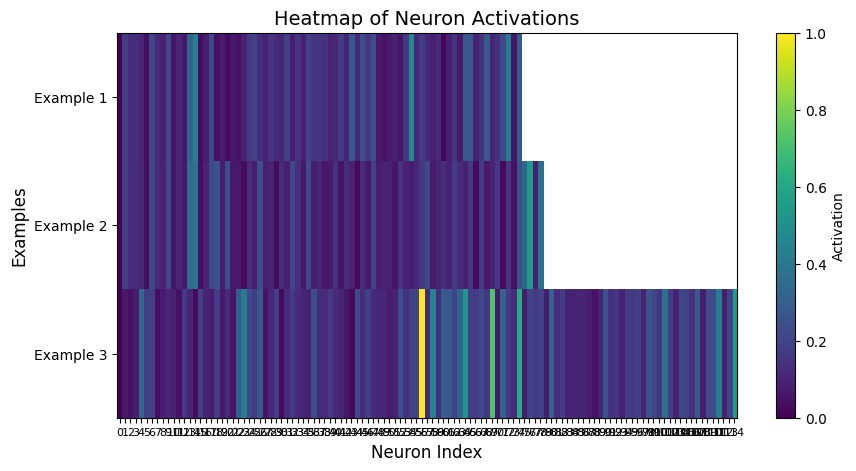

In [88]:
import numpy as np

def pad_activations(activations):
    max_len = max([len(act) for act in activations])
    padded_activations = []
    for act in activations:
        pad_len = max_len - len(act)
        padded_act = np.pad(act, (0, pad_len), constant_values=np.nan)
        padded_activations.append(padded_act)
    return np.array(padded_activations)



# Pad the activations
padded_activations = pad_activations(fortran_acts)

# Normalize the activations
normalized_activations = normalize_activations(padded_activations)

# Convert to NumPy masked array to handle nan values
masked_array = np.ma.masked_invalid(normalized_activations)

# Create the heatmap
plt.figure(figsize=(10, 5))
plt.imshow(masked_array, cmap='viridis', aspect='auto')
plt.colorbar(label='Activation')
plt.xticks(range(len(normalized_activations[0])), fontsize=8)
plt.yticks(range(len(normalized_activations)), ['Example 1', 'Example 2', 'Example 3'], fontsize=10)
plt.xlabel('Neuron Index', fontsize=12)
plt.ylabel('Examples', fontsize=12)
plt.title('Heatmap of Neuron Activations', fontsize=14)
plt.show()


In [30]:
#The END